In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
from fuzzywuzzy import fuzz, process
import unidecode

C:\Users\Francisco\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def add_date_data(DF):
    DF_dates=pd.DataFrame({'date':DF.date.unique(),'year':0,
                          'month':0,'month_day':0,
                          'year_day':0,'weekday':0,
                          'week':0})

    for ind in DF_dates.index:
        date=DF_dates.date[ind]
        date_st=date.timetuple()
        DF_dates.loc[ind,'year']=date_st.tm_year
        DF_dates.loc[ind,'month']=date_st.tm_mon
        DF_dates.loc[ind,'month_day']=date_st.tm_mday
        DF_dates.loc[ind,'year_day']=date_st.tm_yday
        DF_dates.loc[ind,'weekday']=date_st.tm_wday
        DF_dates.loc[ind,'week']=date.isocalendar()[1]
        
        
    DF=DF.merge(DF_dates, on='date')
    return DF

def fix_dam_name(x):
    return unidecode.unidecode(x.strip())

In [3]:
DF_energy=pd.read_csv('../../Data/subsystem_all_dams/Energy_generated_daily_by_dam.csv.zip')
DF_energy['date']=pd.to_datetime(DF_energy.date)
DF_energy['dam']=DF_energy.dam.apply(fix_dam_name)

In [4]:
DF_flow=pd.read_csv('../../Data/subsystem_all_dams/Influent_flow_daily_by_dam.csv.zip')
DF_flow['date']=pd.to_datetime(DF_flow.date)
DF_flow['dam']=DF_flow.dam.apply(fix_dam_name)

In [5]:
DF_Demand=pd.read_csv('../../Data/1999_2021/aggragate_daily_data_2000to2020.csv')
DF_Demand=DF_Demand[['date','maximum_demand']]
DF_Demand.date=pd.to_datetime(DF_Demand.date)

In [6]:
#Names of the dams
A=DF_flow.dam.unique()
B=DF_energy.dam.unique()

In [7]:
Important_Dams=['M. MORAES', 'FURNAS', 'A. VERMELHA', 'MARIMBONDO', 
                 'PARAIBUNA', 'I. SOLTEIRA', 'BATALHA', 'SERRA DO FACAO',
                 'SAO SIMAO', 'EMBORCACAO', 'NOVA PONTE', 'ITUMBIARA',
                 'CAPIVARA', 'JURUMIRIM', 'CHAVANTES', 'TRES MARIAS',
                 'BILLINGS', 'B. BONITA', 'TRES IRMAOS', 'SERRA DA MESA',
                 'ITAIPU']
A=[process.extractOne(a,A)[0] for a in Important_Dams] #Doing this because we checked there is a corresponding one for each. 

In [8]:
#Code to match names
Name_matching=pd.DataFrame({'dam_flow':A,'dam_energy':'', 'score':0, 'others':''})
for ind in Name_matching.index:
    a=Name_matching.loc[ind,'dam_flow']
    matches=process.extractBests(a,B)
    b,score=matches[0]
    Name_matching.loc[ind,['dam_energy','score']]=[b,score]
    if score<100:
        Name_matching.loc[ind,'others']=' | '.join([m[0] for m in matches[1:]])
with pd.option_context('display.max_colwidth', -1):
    display(Name_matching.sort_values('score', ascending=False))
Names_dict={Name_matching.dam_flow[ind]:Name_matching.dam_energy[ind] for ind in Name_matching.index if Name_matching.score[ind]>=90}

,dam_flow,dam_energy,score,others
10,NOVA PONTE,NOVA PONTE,100,
9,EMBORCACAO,EMBORCACAO,100,
19,SERRA DA MESA,SERRA DA MESA,100,
18,TRES IRMAOS,TRES IRMAOS,100,
15,TRES MARIAS,TRES MARIAS,100,
14,CHAVANTES,CHAVANTES,100,
1,FURNAS,FURNAS,100,
20,ITAIPU,ITAIPU,100,
6,BATALHA,BATALHA,100,
4,PARAIBUNA,PARAIBUNA,100,


In [9]:
Names_dict['S.DO FACAO']='SERRA DO FACAO'
Names_dict['I. SOLTEIRA']='COMPLEXO ILHA SOLTEIRA'
Names_dict['M MORAES']='SEN. JOSE ERMIRIO DE MORALS'
Names_dict['B. BONITA']='BARRA BONITA'
Name_matching=pd.DataFrame({'dam_flow':Names_dict.keys(), 'dam_energy':[Names_dict[k] for k in Names_dict.keys()]})
Name_matching

,dam_flow,dam_energy
0,FURNAS,FURNAS
1,MARIMBONDO,MARIMBONDO
2,PARAIBUNA,PARAIBUNA
3,BATALHA,BATALHA
4,SAO SIMAO,SAO SIMAO (CEMIG)
5,EMBORCACAO,EMBORCACAO
6,NOVA PONTE,NOVA PONTE
7,ITUMBIARA,ITUMBIARA (FURNAS)
8,CHAVANTES,CHAVANTES
9,TRES MARIAS,TRES MARIAS


In [10]:
#Add basins
basins=['GRANDE',
 'GRANDE',
 'PARAIBO DO SUL',
 'PARANAIBA',
 'PARANAIBA',
 'PARANAIBA',
 'PARANAIBA',
 'PARANAIBA',
 'PARANAPANEMA',
 'SAO FRANCISCO',
 'TIETE',
 'TOCANTINS',
 'PARANA',
 'PARANAIBA',
 'PARANA',
 'GRANDE',
 'TIETE']
Name_matching['basin']=basins
Name_matching.groupby(['basin','dam_energy']).count().drop('dam_flow',axis=1)

Empty DataFrame
Columns: []
Index: [(GRANDE, FURNAS), (GRANDE, MARIMBONDO), (GRANDE, SEN. JOSE ERMIRIO DE MORALS), (PARAIBO DO SUL, PARAIBUNA), (PARANA, COMPLEXO ILHA SOLTEIRA), (PARANA, ITAIPU), (PARANAIBA, BATALHA), (PARANAIBA, EMBORCACAO), (PARANAIBA, ITUMBIARA (FURNAS)), (PARANAIBA, NOVA PONTE), (PARANAIBA, SAO SIMAO (CEMIG)), (PARANAIBA, SERRA DO FACAO), (PARANAPANEMA, CHAVANTES), (SAO FRANCISCO, TRES MARIAS), (TIETE, BARRA BONITA), (TIETE, TRES IRMAOS), (TOCANTINS, SERRA DA MESA)]

In [11]:
#We consider just the Matchs for which we are sure
# Name_matching[((Name_matching.score>=90) & (Name_matching.score<100))| (Name_matching.dam_energy==' BARRA BONITA')].sort_values('score')
# incorrect_matching=['SALTO', 'ANTA', 'ITÁ']
# Name_matching=Name_matching[((Name_matching.score>=90) &\
#                             ([not(name in incorrect_matching) for name in Name_matching.dam_flow])) |\
#                             (Name_matching.dam_energy==' BARRA BONITA')][['dam_flow','dam_energy']]

In [12]:
All_DF=DF_flow.merge(Name_matching,how='inner',left_on='dam', right_on='dam_flow').drop('dam',axis=1)

In [13]:
All_DF=All_DF.merge(DF_energy, how='inner',left_on=['date','dam_energy'], right_on=['date','dam']).drop('dam',axis=1)

In [14]:
All_DF=All_DF.merge(DF_Demand,on='date')

In [15]:
All_DF=add_date_data(All_DF)

In [16]:
#Now we  aggregate
All_DF_monthly=All_DF.groupby(['year','month','dam_energy']).agg(energy_generated=('energy_generated','sum'),influent_flow=('influent_flow','sum'),
                                                 dam_flow=('dam_flow',lambda x: ' & '.join([str(a) for a in x.unique()])),
                                                 maximum_demand=('maximum_demand','sum')).reset_index()
All_DF_monthly

,year,month,dam_energy,energy_generated,influent_flow,dam_flow,maximum_demand
0,2000,1,BARRA BONITA,42.058100,17948.34,B. BONITA,937624.000
1,2000,1,CHAVANTES,176.063700,7944.10,CHAVANTES,937624.000
2,2000,1,COMPLEXO ILHA SOLTEIRA,1291.327700,167163.45,I. SOLTEIRA,937624.000
3,2000,1,EMBORCACAO,215.318400,21503.00,EMBORCACAO,937624.000
4,2000,1,FURNAS,493.535600,67513.02,FURNAS,937624.000
...,...,...,...,...,...,...,...
3543,2019,12,SAO SIMAO (CEMIG),851.197656,67268.67,SAO SIMAO,1315998.779
3544,2019,12,SERRA DA MESA,336.785099,8143.50,SERRA DA MESA,1315998.779
3545,2019,12,SERRA DO FACAO,39.262169,2710.14,S.DO FACAO,1315998.779
3546,2019,12,TRES IRMAOS,290.170607,24632.62,TRES IRMAOS,1315998.779


In [17]:
All_DF['log_flow']=np.log(All_DF.influent_flow)
All_DF_monthly['log_flow']=np.log(All_DF_monthly.influent_flow)

C:\Users\Francisco\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
import random
from plotnine import *

In [19]:
Corr_DF=pd.DataFrame({'dam_energy':All_DF.dam_energy.unique(),'corr_energy':0,'corr_demand':0})
for ind in Corr_DF.index:
    dam=Corr_DF.loc[ind,'dam_energy']
    DF=All_DF_monthly[All_DF_monthly.dam_energy==dam]
    Corr_DF.loc[ind,'corr_energy']=np.corrcoef(DF.energy_generated, DF.influent_flow)[0,1]
    Corr_DF.loc[ind,'corr_demand']=np.corrcoef(DF.energy_generated, DF.maximum_demand)[0,1]

In [20]:
Corr_DF.sort_values('corr_demand', ascending=False).head(10)

,dam_energy,corr_energy,corr_demand
8,ITAIPU,0.343922,0.164537
15,BATALHA,-0.197885,0.145299
14,SERRA DO FACAO,0.391762,0.110379
12,CHAVANTES,0.585883,0.109140
1,TRES IRMAOS,0.759592,0.091253
4,PARAIBUNA,-0.192669,0.072355
5,NOVA PONTE,-0.012110,0.015820
10,FURNAS,0.132917,0.006795
6,MARIMBONDO,0.731922,-0.008116
13,BARRA BONITA,0.765422,-0.027381


In [21]:
# dam='BATALHA'
# DF2=All_DF_monthly[All_DF_monthly.dam_energy==dam]

# G1=ggplot(DF2,aes(x='month',y='energy_generated',color='factor(year)'))+geom_line()+ggtitle(dam)
# G2=ggplot(DF2,aes(x='month',y='influent_flow',color='factor(year)'))+geom_line()
# G3=ggplot(DF2,aes(x='month',y='maximum_demand',color='factor(year)'))+geom_line()

# G1.draw()
# G2.draw()
# G3.draw()

In [22]:
Corr_DF_daily=pd.DataFrame({'dam_energy':All_DF.dam_energy.unique(),'corr_energy':0,'corr_demand':0})
for ind in Corr_DF.index:
    dam=Corr_DF.loc[ind,'dam_energy']
    DF=All_DF[All_DF.dam_energy==dam]
    Corr_DF_daily.loc[ind,'corr_energy']=np.corrcoef(DF.energy_generated, DF.influent_flow)[0,1]
    Corr_DF_daily.loc[ind,'corr_demand']=np.corrcoef(DF.energy_generated, DF.maximum_demand)[0,1]

In [23]:
Corr_DF_daily.sort_values('corr_energy',ascending=False).head(10)

,dam_energy,corr_energy,corr_demand
9,COMPLEXO ILHA SOLTEIRA,0.692165,0.071216
6,MARIMBONDO,0.605374,0.111173
13,BARRA BONITA,0.556794,0.050772
1,TRES IRMAOS,0.553984,0.184878
3,SAO SIMAO (CEMIG),0.553457,0.066109
12,CHAVANTES,0.425746,0.172733
7,ITUMBIARA (FURNAS),0.340427,0.119249
14,SERRA DO FACAO,0.309276,0.197397
0,TRES MARIAS,0.264187,-0.294978
8,ITAIPU,0.226512,0.218456


In [24]:
Corr_DF_daily=pd.DataFrame({'dam_energy':All_DF.dam_energy.unique(),'corr':0})
for ind in Corr_DF_daily.index:
    dam=Corr_DF.loc[ind,'dam_energy']
    DF=All_DF[All_DF.dam_energy==dam]
    Corr_DF_daily.loc[ind,'corr']=np.corrcoef(DF.energy_generated, DF.influent_flow)[0,1]
Corr_DF_daily['abs_corr']=np.abs(Corr_DF_daily['corr'])

In [25]:
Corr_DF_daily.sort_values('abs_corr',ascending=False)

,dam_energy,corr,abs_corr
9,COMPLEXO ILHA SOLTEIRA,0.692165,0.692165
6,MARIMBONDO,0.605374,0.605374
13,BARRA BONITA,0.556794,0.556794
1,TRES IRMAOS,0.553984,0.553984
3,SAO SIMAO (CEMIG),0.553457,0.553457
12,CHAVANTES,0.425746,0.425746
7,ITUMBIARA (FURNAS),0.340427,0.340427
14,SERRA DO FACAO,0.309276,0.309276
0,TRES MARIAS,0.264187,0.264187
8,ITAIPU,0.226512,0.226512


C:\Users\Francisco\anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


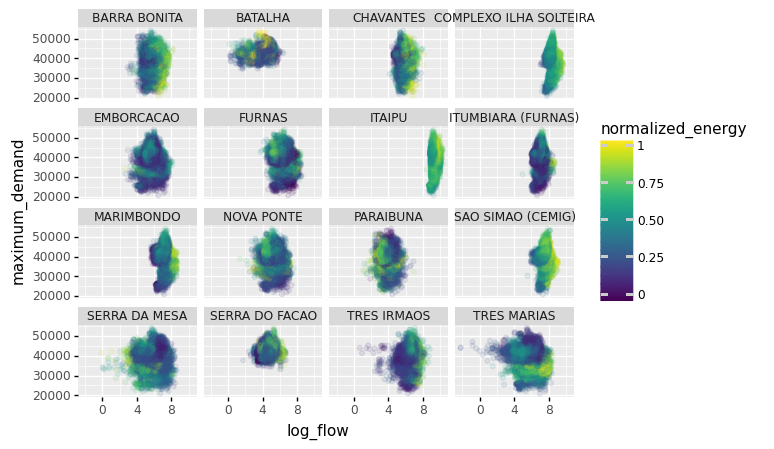

<ggplot: (103297250744)>

In [142]:
DF2=All_DF.copy()
DF2['normalized_energy']=All_DF[['dam_energy', 'energy_generated']].\
    groupby('dam_energy',group_keys=False).apply(lambda x: x/x.max())

ggplot(DF2,aes(x='log_flow',y='maximum_demand',color='normalized_energy',group='dam_energy'))+\
geom_point(alpha=0.1)+facet_wrap('dam_energy')


In [27]:
All_DF_all=All_DF.groupby(['year','month','date','year_day']).agg(maximum_demand=('maximum_demand','max'),
                                                        influent_flow=('influent_flow','sum'),
                                                        energy_generated=('energy_generated','sum')).reset_index()

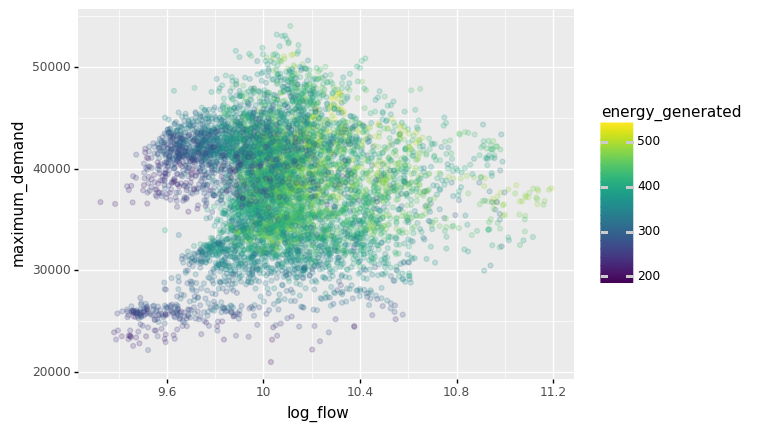

<ggplot: (103310584757)>

In [146]:
All_DF_all['log_flow']=np.log(All_DF_all.influent_flow)
ggplot(All_DF_all,aes(x='log_flow',y='maximum_demand',color='energy_generated'))+\
geom_point(alpha=0.2)


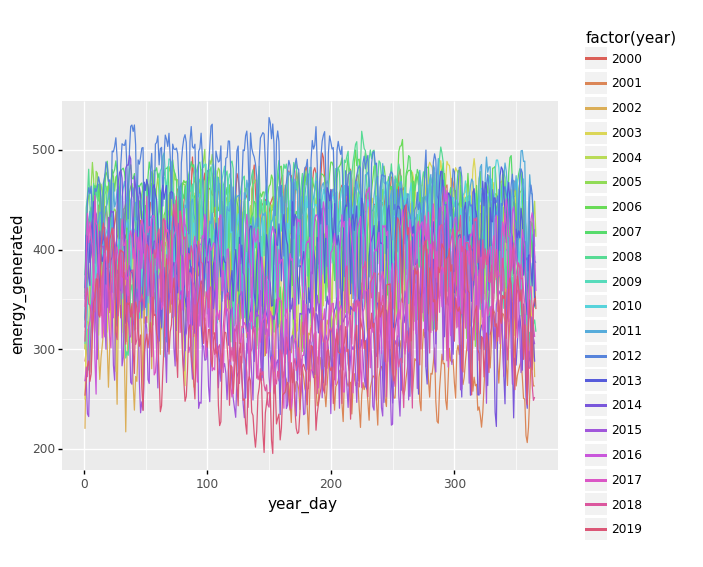

<ggplot: (103295503068)>

In [29]:
ggplot(All_DF_all,aes(x='year_day',y='energy_generated', color='factor(year)'))+\
geom_line()

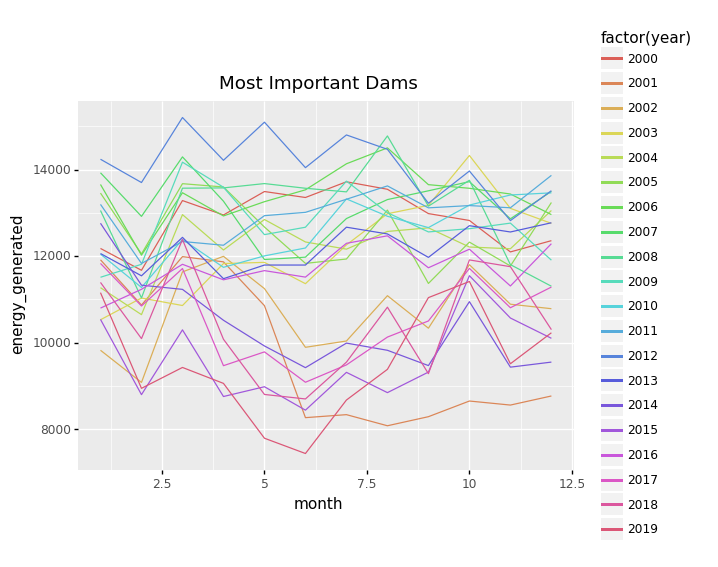

<ggplot: (103291545266)>

In [34]:
All_DF_monthly_all=All_DF.groupby(['year','month']).agg(maximum_demand=('maximum_demand','max'),
                                                        influent_flow=('influent_flow','sum'),
                                                        energy_generated=('energy_generated','sum')).reset_index()
ggplot(All_DF_monthly_all,aes(x='month',y='energy_generated', color='factor(year)'))+\
geom_line()+ggtitle('Most Important Dams')

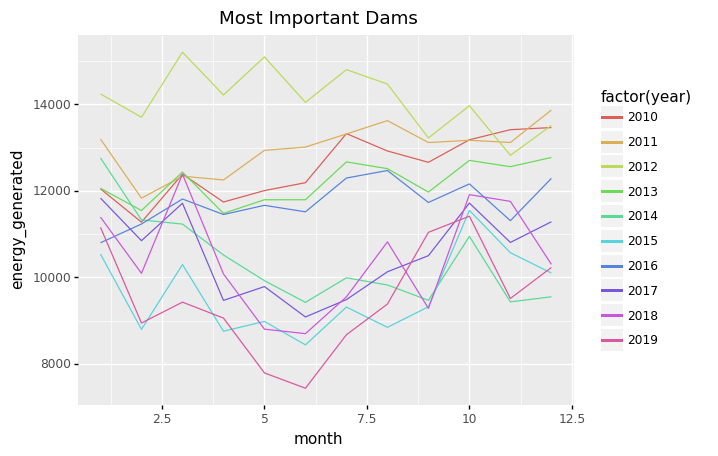

<ggplot: (103287164850)>

In [48]:
ggplot(All_DF_monthly_all[All_DF_monthly_all.year>=2010],aes(x='month',y='energy_generated', color='factor(year)'))+\
geom_line()+ggtitle('Most Important Dams')

In [32]:
# All_DF.rename({'dam_flow':'dam'}, axis=1, inplace=True)
# All_DF=All_DF[['date', 'basin','dam', 'influent_flow', 'maximum_demand','energy_generated']]
# All_DF.to_csv('../../Data/subsystem_all_dams/Energy_and_Flow_per_dam_daily.csv.zip')

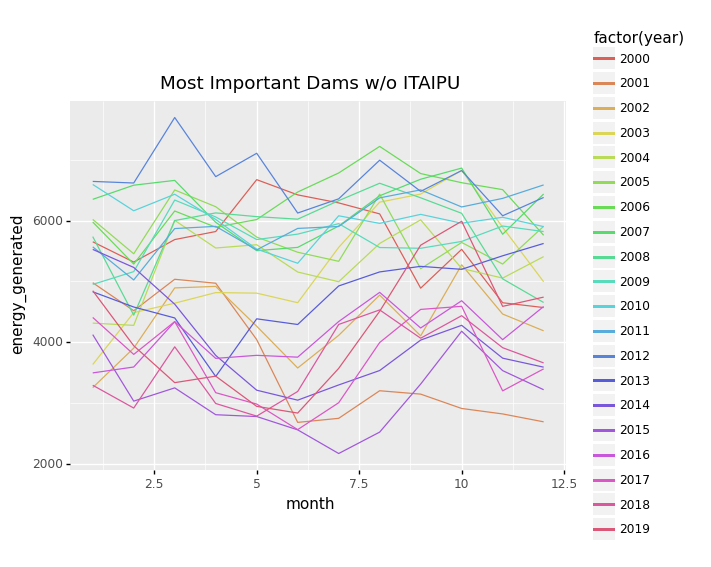

<ggplot: (103297348081)>

In [45]:
DF=All_DF[All_DF.dam_energy!='ITAIPU'].groupby(['year','month']).agg(energy_generated=('energy_generated','sum')).reset_index()

ggplot(DF,aes(x='month',y='energy_generated', color='factor(year)'))+\
geom_line()+ggtitle('Most Important Dams w/o ITAIPU')

# Try random trees

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

In [132]:
for dam in All_DF.dam_energy.unique(): 
    DF=All_DF[All_DF.dam_energy==dam]
    X=np.c_[DF[['influent_flow', 'maximum_demand']],OneHotEncoder(sparse=False).fit_transform(DF[['month']])]
    y=np.array(DF['energy_generated'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

    RF = RandomForestRegressor(random_state = 17)
    RF.fit(X_train, y_train)

    y_pred = RF.predict(X_test)
    Importance = pd.DataFrame({'Importance':RF.feature_importances_*100}, 
                         index = ['influent_flow', 'maximum_demand', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])
    Importance = Importance.sort_values(by = 'Importance',ascending=False)
    mae=mean_absolute_error(y_test, y_pred)

    print('For dam: ', dam)
    print("random forest MAE:", mae)
    print("MAE/(mean value)*100:", np.ceil(mae/np.mean(DF.energy_generated)*100),'%')
    Importance.head(2)
    print('---------------------------------------------------------------------\n\n')

For dam:  TRES MARIAS
random forest MAE: 1.0550194460518822
MAE/(mean value)*100: 23.0 %
---------------------------------------------------------------------


For dam:  TRES IRMAOS
random forest MAE: 2.3209791574587957
MAE/(mean value)*100: 35.0 %
---------------------------------------------------------------------


For dam:  SERRA DA MESA
random forest MAE: 3.636406515001985
MAE/(mean value)*100: 29.0 %
---------------------------------------------------------------------


For dam:  SAO SIMAO (CEMIG)
random forest MAE: 3.8835495437136203
MAE/(mean value)*100: 14.0 %
---------------------------------------------------------------------


For dam:  PARAIBUNA
random forest MAE: 0.2522926775112936
MAE/(mean value)*100: 28.0 %
---------------------------------------------------------------------


For dam:  NOVA PONTE
random forest MAE: 1.721381805999521
MAE/(mean value)*100: 33.0 %
---------------------------------------------------------------------


For dam:  MARIMBONDO
random for

In [134]:
DF=All_DF_monthly_all
X=np.c_[DF[['influent_flow', 'maximum_demand']],OneHotEncoder(sparse=False).fit_transform(DF[['month']])]
y=np.array(DF['energy_generated'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

RF = RandomForestRegressor(random_state = 17)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)
Importance = pd.DataFrame({'Importance':RF.feature_importances_*100}, 
                         index = ['influent_flow', 'maximum_demand', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])
Importance = Importance.sort_values(by = 'Importance',ascending=False)
mae=mean_absolute_error(y_test, y_pred)

print('FOR THE WHOLE 17 DAMS TOGETHER------------')
print("random forest MAE:", mae)
print("MAE/(mean value)*100:", np.ceil(mae/np.mean(DF.energy_generated)*100),'%')

Importance.head(2)

FOR THE WHOLE 17 DAMS TOGETHER------------
random forest MAE: 652.2422546746882
MAE/(mean value)*100: 6.0 %


,Importance
influent_flow,58.017328
maximum_demand,29.699861


In [136]:
DF=All_DF_monthly_all
X=np.c_[DF[['influent_flow', 'maximum_demand']],OneHotEncoder(sparse=False).fit_transform(DF[['month']])]
y=np.array(DF['energy_generated'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

RF = RandomForestRegressor(random_state = 17, max_depth=1)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)
Importance = pd.DataFrame({'Importance':RF.feature_importances_*100}, 
                         index = ['influent_flow', 'maximum_demand', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'])
Importance = Importance.sort_values(by = 'Importance',ascending=False)
mae=mean_absolute_error(y_test, y_pred)

print('FOR THE WHOLE 17 DAMS TOGETHER (Just one level)------------')
print("random forest MAE:", mae)
print("MAE/(mean value)*100:", np.ceil(mae/np.mean(DF.energy_generated)*100),'%')

Importance.head(2)

FOR THE WHOLE 17 DAMS TOGETHER (Just one level)------------
random forest MAE: 1001.8815492831827
MAE/(mean value)*100: 9.0 %


,Importance
influent_flow,100.0
maximum_demand,0.0
